# Naive value iteration, using a hungry lion
We start by creating a model of a lion. Whenever it gets hungry, it will go hunting and hopefully catch a prey. However, if it fails, it might starve to death...

In [2]:
from stormvogel.model import Model, ModelType, Branch, Transition

lion = Model(name="lion", model_type=ModelType.MDP)
init = lion.get_initial_state()
full = lion.new_state("full :D")
satisfied = lion.new_state("satisfied :)")
hungry = lion.new_state("hungry :(")
starving = lion.new_state("starving :((")
dead = lion.new_state("dead...")

hunt = lion.new_action("hunt >:D")
rawr = lion.new_action("rawr")

init.set_transitions([(1, satisfied)])

full.set_transitions(Transition({
    hunt: Branch([
        (0.5, satisfied),
        (0.5, full),
    ]),
    rawr: Branch([
        (0.9, full),
        (0.1, satisfied)
    ])
}))

satisfied.set_transitions(Transition({
    hunt: Branch([
        (0.5, satisfied),
        (0.3, full),
        (0.2, hungry)
    ]),
    rawr: Branch([
        (0.9, satisfied),
        (0.1, hungry)
    ])
}))

hungry.set_transitions(Transition({
    hunt: Branch([
        (0.2, full),
        (0.5, satisfied),
        (0.1, hungry),
        (0.2, starving)
    ]),
    rawr: Branch([
        (0.9, hungry),
        (0.1, starving)
    ])
}))

starving.set_transitions(Transition({
    hunt: Branch([
        (0.1, full),
        (0.5, satisfied),
        (0.2, hungry),
        (0.2, dead)
    ]),
    rawr: Branch([
        (0.9, starving),
        (0.1, dead)
    ])
}))
lion.add_self_loops()

from stormvogel.show import show
from stormvogel.layout import Layout
vis = show(lion, layout=Layout("layouts/lion.json"), name="lion", save_and_embed=True)

Here we provide an implementation of naive value iteration using the model API.

In [3]:
import stormvogel.model

def naive_value_iteration(
    model: stormvogel.model.Model, epsilon: float, target_state: stormvogel.model.State
) -> list[list[float]]:
    """Run naive value iteration. The result is a 2D list where result[n][m] is the probability to be in state m at step n.

    Args:
        model (stormvogel.model.Model): Target model.
        steps (int): Amount of steps.
        target_state (stormvogel.model.State): Target state of the model.

    Returns:
        list[list[float]]: The result is a 2D list where result[n][m] is the value of state m at iteration n.
    """
    if epsilon <= 0:
        RuntimeError("The algorithm will not terminate if epsilon is zero.")

    # Create a dynamic matrix (list of lists) to store the result.
    values_matrix = [[0 for state in model.get_states()]]
    values_matrix[0][target_state.id] = 1

    terminate = False
    while not terminate:
        old_values = values_matrix[len(values_matrix) - 1]
        new_values = [None for state in model.get_states()]
        for sid, state in model.get_states().items():
            transitions = model.get_transitions(state)
            # Now we have to take a decision for an action.
            actions = transitions.transition.keys()
            action_values = {}
            for action, branch in transitions.transition.items():
                branch_value = sum([prob * old_values[state.id] for (prob, state) in branch.branch])
                action_values[action] = branch_value
            # We take the action with the highest value.
            highest_value = max(action_values.values())
            new_values[sid] = highest_value
        values_matrix.append(new_values)
        terminate = sum([abs(x-y) for (x, y) in zip(new_values, old_values)]) < epsilon
    return values_matrix
        

We apply naive value iteration on our lion model with 20 steps. Then we display the result of the as a heatmap, using matplotlib.

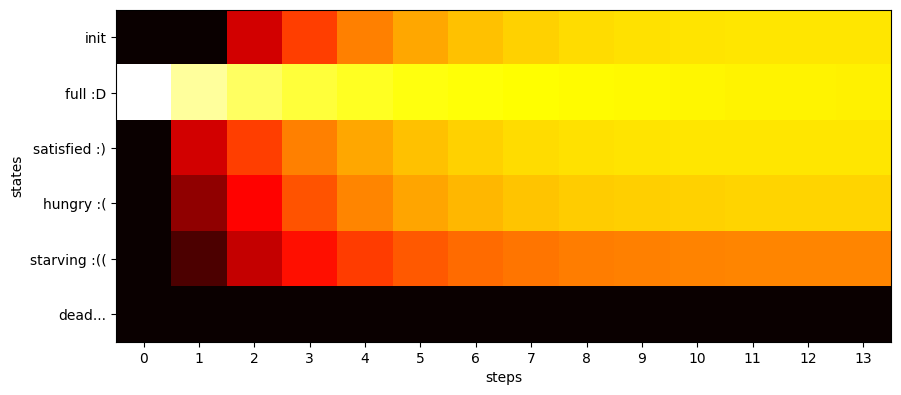

In [4]:
import stormvogel.lib
res = naive_value_iteration(lion, 0.003, full)
labels = [s.labels[0] for s in lion.get_states().values()]
stormvogel.lib.display_value_iteration_result(res, 10, labels)

Note that naive_value_iteration is also available under stormvogel.lib, in case you would like to use it later. However, this implementation is very inefficient so we recommend using the value iteration algorithms from stormpy if you want good performance.

In [6]:
import stormvogel.lib
res2 = stormvogel.lib.naive_value_iteration(lion, 0.003, full)
assert res == res2